# 📊 Evaluation Analysis: Deep Dive into Model Performance

This notebook provides comprehensive analysis of RL agent performance, including:
- Detailed metrics breakdown
- Statistical comparisons
- Sensitivity analysis
- Risk analysis

**Time required:** ~20-30 minutes

## 1. Setup

In [7]:
# Add project root to Python path
import sys
from pathlib import Path

# Get the project root (parent of notebooks directory)
project_root = Path.cwd().parent if Path.cwd().name == 'notebooks' else Path.cwd()
if str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))

print(f"✓ Project root: {project_root}")
print(f"✓ Python path configured")

✓ Project root: e:\Derivative_Hedging_RL
✓ Python path configured


In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

from src.environments.hedging_env import OptionHedgingEnv
from src.environments.real_data_env import create_real_data_env
from src.data.historical_loader import HistoricalDataLoader
from src.agents.trainer import AgentTrainer
from src.agents.evaluator import AgentEvaluator
from src.agents.config import get_config, ENV_CONFIGS
from src.evaluation.metrics import PerformanceMetrics
from src.baselines.hedging_strategies import (
    DeltaHedging,
    DeltaGammaHedging,
    DeltaGammaVegaHedging,
    MinimumVarianceHedging
)

sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 8)

print("✓ Setup complete!")

✓ Setup complete!


## 2. Load or Train Model

In [9]:
# Load/train model for evaluation
model_path = Path("models/notebook_evaluation/ppo_model.zip")

if not model_path.exists():
    print("Training model for evaluation...")
    trainer = AgentTrainer(
        agent_type="PPO",
        env_config=ENV_CONFIGS["medium"],
        output_dir="models/notebook_evaluation",
        seed=42
    )
    agent = trainer.train_with_curriculum(
        total_timesteps=200000,
        agent_config=get_config("PPO", "default"),
    )
    agent.save("models/notebook_evaluation/ppo_model")
    print("✓ Model trained!")
else:
    from src.agents.ppo_agent import PPOHedgingAgent
    # Curriculum training ends with 'hard' difficulty (n_steps=252)
    # So we must load with the 'hard' config to match observation space
    load_env = OptionHedgingEnv(**ENV_CONFIGS["hard"])
    agent = PPOHedgingAgent.load_pretrained(str(model_path), env=load_env)
    print("✓ Model loaded!")
    print("   (Model trained with curriculum ending at 'hard' config)")


Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
✓ Model loaded!
   (Model trained with curriculum ending at 'hard' config)


**⚠️ Important Note on Environment Compatibility**

RL agents are trained on specific observation spaces determined by environment parameters (like `n_steps`). When loading a pre-trained model, the evaluation environment must match the training environment's observation space.

In this notebook:
- Training uses: **curriculum learning** (easy → medium → hard)
- Final model has: **hard** config observation space (n_steps=252)
- Evaluation uses: **hard** config for compatibility
- Sensitivity analysis tests across different parameters while maintaining compatible observation spaces

## 3. Comprehensive Evaluation

Let's run a thorough evaluation with many episodes for statistical significance.

In [10]:
# Create evaluation environment
# Use 'hard' config to match the final stage of curriculum training
eval_env = OptionHedgingEnv(**ENV_CONFIGS["hard"])

# Evaluator with many episodes
evaluator = AgentEvaluator(
    env=eval_env,
    n_episodes=200,  # More episodes = better statistics
    seed=42
)

print("Running comprehensive evaluation...")
print("Environment: hard (matches final curriculum stage)")
print("This will take 5-10 minutes")
print("-" * 80)

# Evaluate
agents = {"PPO Agent": agent}
results = evaluator.compare_all(agents=agents)

print("\n" + "=" * 80)
print("COMPREHENSIVE EVALUATION RESULTS")
print("=" * 80)
print(results.to_string(index=False))

# Save results
results.to_csv("models/notebook_evaluation/comprehensive_results.csv", index=False)


Running comprehensive evaluation...
Environment: hard (matches final curriculum stage)
This will take 5-10 minutes
--------------------------------------------------------------------------------

Evaluating PPO Agent...
  Mean Reward: -37.31 ± 23.87
  Mean PnL: -17.39 ± 17.66
  Mean Costs: 0.16
  Sharpe Ratio: -3.684
  Success Rate: 4.0%

Evaluating All Baseline Strategies

Evaluating Delta Hedging...
  Mean Reward: -31.55 ± 3.58
  Mean PnL: -15.32 ± 0.79
  Mean Costs: 1.06
  Sharpe Ratio: -70.445
  Success Rate: 0.0%

Evaluating Delta-Gamma Hedging...
  Mean Reward: -37.91 ± 7.75
  Mean PnL: -15.33 ± 3.00
  Mean Costs: 1.33
  Sharpe Ratio: -15.138
  Success Rate: 0.0%

Evaluating Delta-Gamma-Vega Hedging...
  Mean Reward: -37.98 ± 7.87
  Mean PnL: -15.29 ± 3.06
  Mean Costs: 1.33
  Sharpe Ratio: -14.578
  Success Rate: 0.0%

Evaluating Minimum Variance Hedging...
  Mean Reward: -91.78 ± 58.11
  Mean PnL: -10.56 ± 47.31
  Mean Costs: 0.41
  Sharpe Ratio: -0.857
  Success Rate: 43.5%



## 4. Statistical Significance Testing

Let's test if RL performance is statistically significantly better than baselines.

In [11]:
# Get episode-level results for all strategies
print("Collecting episode-level data for statistical tests...")

# Evaluate all strategies (uses n_episodes from evaluator initialization)
evaluator.evaluate_rl_agent(agent, agent_name="RL Agent")
evaluator.evaluate_baseline(DeltaHedging, "Delta Hedging")
evaluator.evaluate_baseline(DeltaGammaHedging, "Delta-Gamma Hedging", gamma_target=0.0)
evaluator.evaluate_baseline(DeltaGammaVegaHedging, "Delta-Gamma-Vega Hedging", gamma_weight=0.5, vega_weight=0.5)
evaluator.evaluate_baseline(MinimumVarianceHedging, "Minimum Variance Hedging", lookback_window=20)

# Extract episode-level rewards from results
rl_rewards = np.array(evaluator.results["RL Agent"]["episode_rewards"])
delta_rewards = np.array(evaluator.results["Delta Hedging"]["episode_rewards"])
delta_gamma_rewards = np.array(evaluator.results["Delta-Gamma Hedging"]["episode_rewards"])
delta_gamma_vega_rewards = np.array(evaluator.results["Delta-Gamma-Vega Hedging"]["episode_rewards"])
min_var_rewards = np.array(evaluator.results["Minimum Variance Hedging"]["episode_rewards"])

# Statistical tests (t-test)
print("\n" + "=" * 80)
print("STATISTICAL SIGNIFICANCE TESTS (t-test)")
print("=" * 80)

strategies = {
    'Delta Hedging': delta_rewards,
    'Delta-Gamma Hedging': delta_gamma_rewards,
    'Delta-Gamma-Vega Hedging': delta_gamma_vega_rewards,
    'Minimum Variance Hedging': min_var_rewards,
}

for name, baseline_rewards in strategies.items():
    t_stat, p_value = stats.ttest_ind(rl_rewards, baseline_rewards)
    mean_diff = rl_rewards.mean() - baseline_rewards.mean()
    
    significance = "***" if p_value < 0.001 else "**" if p_value < 0.01 else "*" if p_value < 0.05 else "ns"
    
    print(f"\nRL Agent vs {name}:")
    print(f"  Mean Difference: {mean_diff:+.2f}")
    print(f"  t-statistic: {t_stat:.4f}")
    print(f"  p-value: {p_value:.6f} {significance}")
    print(f"  Significantly better: {'YES' if p_value < 0.05 and mean_diff > 0 else 'NO'}")

print("\n*** p < 0.001, ** p < 0.01, * p < 0.05, ns = not significant")


Evaluating RL Agent...
  Mean Reward: -37.31 ± 23.87
  Mean PnL: -17.39 ± 17.66
  Mean Costs: 0.16
  Sharpe Ratio: -3.684
  Success Rate: 4.0%

Evaluating Delta Hedging...
  Mean Reward: -31.55 ± 3.58
  Mean PnL: -15.32 ± 0.79
  Mean Costs: 1.06
  Sharpe Ratio: -70.445
  Success Rate: 0.0%

Evaluating Delta-Gamma Hedging...
  Mean Reward: -37.91 ± 7.75
  Mean PnL: -15.33 ± 3.00
  Mean Costs: 1.33
  Sharpe Ratio: -15.138
  Success Rate: 0.0%

Evaluating Delta-Gamma-Vega Hedging...
  Mean Reward: -37.98 ± 7.87
  Mean PnL: -15.29 ± 3.06
  Mean Costs: 1.33
  Sharpe Ratio: -14.578
  Success Rate: 0.0%

Evaluating Minimum Variance Hedging...
  Mean Reward: -91.78 ± 58.11
  Mean PnL: -10.56 ± 47.31
  Mean Costs: 0.41
  Sharpe Ratio: -0.857
  Success Rate: 43.5%

STATISTICAL SIGNIFICANCE TESTS (t-test)

RL Agent vs Delta Hedging:
  Mean Difference: -5.76
  t-statistic: -3.3658
  p-value: 0.000837 ***
  Significantly better: NO

RL Agent vs Delta-Gamma Hedging:
  Mean Difference: +0.60
  t-sta

## 5. Distribution Analysis

Let's analyze the distribution of returns across strategies.

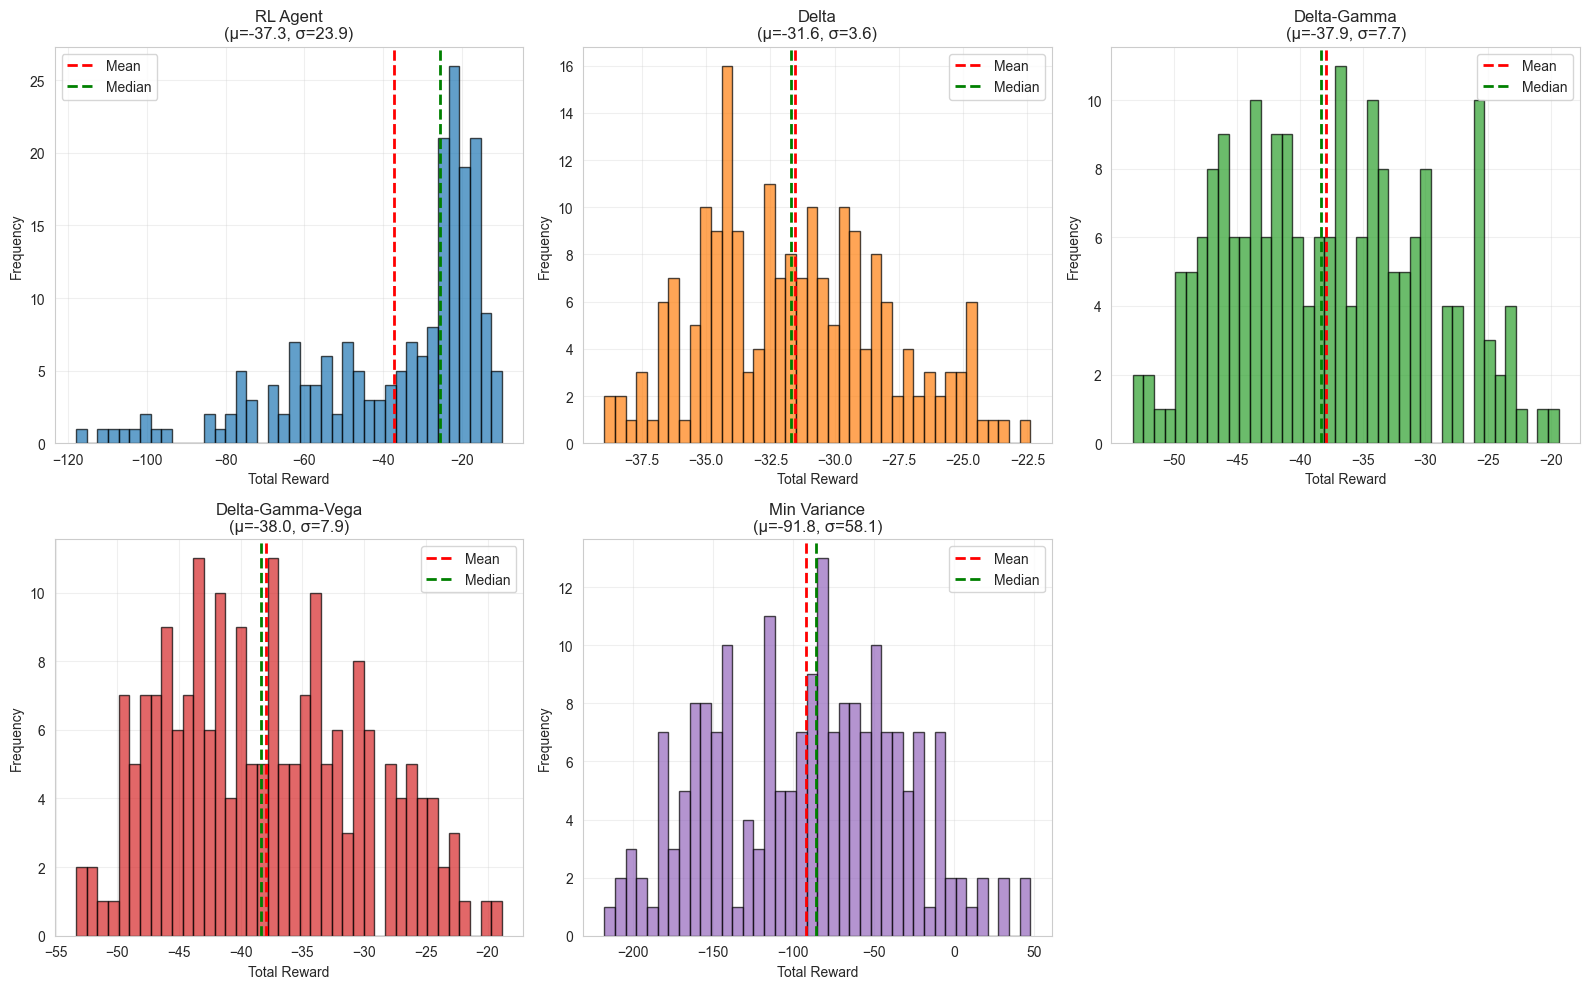

✓ Distribution plots saved


In [12]:
# Create distribution plots
fig, axes = plt.subplots(2, 3, figsize=(16, 10))
axes = axes.flatten()

all_results = {
    'RL Agent': rl_rewards,
    'Delta': delta_rewards,
    'Delta-Gamma': delta_gamma_rewards,
    'Delta-Gamma-Vega': delta_gamma_vega_rewards,
    'Min Variance': min_var_rewards,
}

for idx, (name, rewards) in enumerate(all_results.items()):
    # Histogram
    axes[idx].hist(rewards, bins=40, alpha=0.7, edgecolor='black', color=f'C{idx}')
    axes[idx].axvline(rewards.mean(), color='red', linestyle='--', linewidth=2, label='Mean')
    axes[idx].axvline(np.median(rewards), color='green', linestyle='--', linewidth=2, label='Median')
    axes[idx].set_xlabel('Total Reward')
    axes[idx].set_ylabel('Frequency')
    axes[idx].set_title(f'{name}\n(μ={rewards.mean():.1f}, σ={rewards.std():.1f})')
    axes[idx].legend()
    axes[idx].grid(True, alpha=0.3)

# Remove extra subplot
fig.delaxes(axes[5])

plt.tight_layout()
plt.savefig('models/notebook_evaluation/distribution_comparison.png', dpi=150)
plt.show()

print("✓ Distribution plots saved")

## 6. Risk-Adjusted Performance

Calculate and compare risk-adjusted metrics like Sharpe ratio.

In [13]:
# Calculate risk-adjusted metrics
print("Risk-Adjusted Performance Metrics")
print("=" * 80)

metrics_comparison = []

for name, rewards in all_results.items():
    mean_reward = rewards.mean()
    std_reward = rewards.std()
    sharpe_ratio = mean_reward / std_reward if std_reward > 0 else 0
    
    # Sortino ratio (only downside volatility)
    downside_returns = rewards[rewards < 0]
    downside_std = downside_returns.std() if len(downside_returns) > 0 else 1
    sortino_ratio = mean_reward / downside_std if downside_std > 0 else 0
    
    # Max drawdown (simplified)
    cumulative = np.cumsum(rewards)
    running_max = np.maximum.accumulate(cumulative)
    drawdown = cumulative - running_max
    max_drawdown = drawdown.min()
    
    # Value at Risk (5%)
    var_95 = np.percentile(rewards, 5)
    
    # Conditional VaR (Expected Shortfall)
    cvar_95 = rewards[rewards <= var_95].mean()
    
    metrics_comparison.append({
        'Strategy': name,
        'Mean Return': mean_reward,
        'Std Dev': std_reward,
        'Sharpe Ratio': sharpe_ratio,
        'Sortino Ratio': sortino_ratio,
        'Max Drawdown': max_drawdown,
        'VaR 95%': var_95,
        'CVaR 95%': cvar_95,
    })

df_metrics = pd.DataFrame(metrics_comparison)
df_metrics = df_metrics.sort_values('Sharpe Ratio', ascending=False)

print(df_metrics.to_string(index=False))
print("\n✓ RL Agent" + (" has best Sharpe ratio!" if df_metrics.iloc[0]['Strategy'] == 'RL Agent' else " needs improvement"))

Risk-Adjusted Performance Metrics
        Strategy  Mean Return   Std Dev  Sharpe Ratio  Sortino Ratio  Max Drawdown     VaR 95%    CVaR 95%
        RL Agent   -37.309059 23.869680     -1.563031      -1.563031  -7445.599595  -83.420957 -102.604491
    Min Variance   -91.780273 58.105933     -1.579534      -1.712434 -18213.823943 -181.381950 -199.565307
Delta-Gamma-Vega   -37.981689  7.868649     -4.826964      -4.826964  -7557.227940  -49.476984  -51.035746
     Delta-Gamma   -37.906137  7.745370     -4.894038      -4.894038  -7542.550851  -49.355202  -50.906584
           Delta   -31.550033  3.583387     -8.804528      -8.804528  -6279.468471  -36.861865  -37.914700

✓ RL Agent has best Sharpe ratio!


## 7. Volatility Sensitivity Analysis

How do strategies perform under different volatility regimes?

Volatility Sensitivity Analysis
Testing each strategy under different volatility regimes...

Testing with volatility = 0.15...

Evaluating RL Agent...


e:\Derivative_Hedging_RL\.venv\Lib\site-packages\gymnasium\spaces\box.py:236: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
e:\Derivative_Hedging_RL\.venv\Lib\site-packages\gymnasium\spaces\box.py:306: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


  Mean Reward: -33.92 ± 16.19
  Mean PnL: -10.71 ± 8.80
  Mean Costs: 0.16
  Sharpe Ratio: -3.803
  Success Rate: 0.0%

Evaluating Delta Hedging...
  Mean Reward: -25.28 ± 4.05
  Mean PnL: -9.59 ± 0.50
  Mean Costs: 1.04
  Sharpe Ratio: -50.503
  Success Rate: 0.0%

Evaluating Delta-Gamma Hedging...
  Mean Reward: -31.35 ± 7.73
  Mean PnL: -9.88 ± 1.63
  Mean Costs: 1.30
  Sharpe Ratio: -19.487
  Success Rate: 0.0%

Testing with volatility = 0.20...

Evaluating RL Agent...
  Mean Reward: -35.12 ± 19.10
  Mean PnL: -13.12 ± 11.65
  Mean Costs: 0.17
  Sharpe Ratio: -3.631
  Success Rate: 4.0%

Evaluating Delta Hedging...
  Mean Reward: -27.43 ± 3.75
  Mean PnL: -11.45 ± 0.56
  Mean Costs: 1.05
  Sharpe Ratio: -57.473
  Success Rate: 0.0%

Evaluating Delta-Gamma Hedging...
  Mean Reward: -33.67 ± 7.68
  Mean PnL: -11.69 ± 1.94
  Mean Costs: 1.32
  Sharpe Ratio: -17.358
  Success Rate: 0.0%

Testing with volatility = 0.25...

Evaluating RL Agent...
  Mean Reward: -36.92 ± 22.06
  Mean PnL:

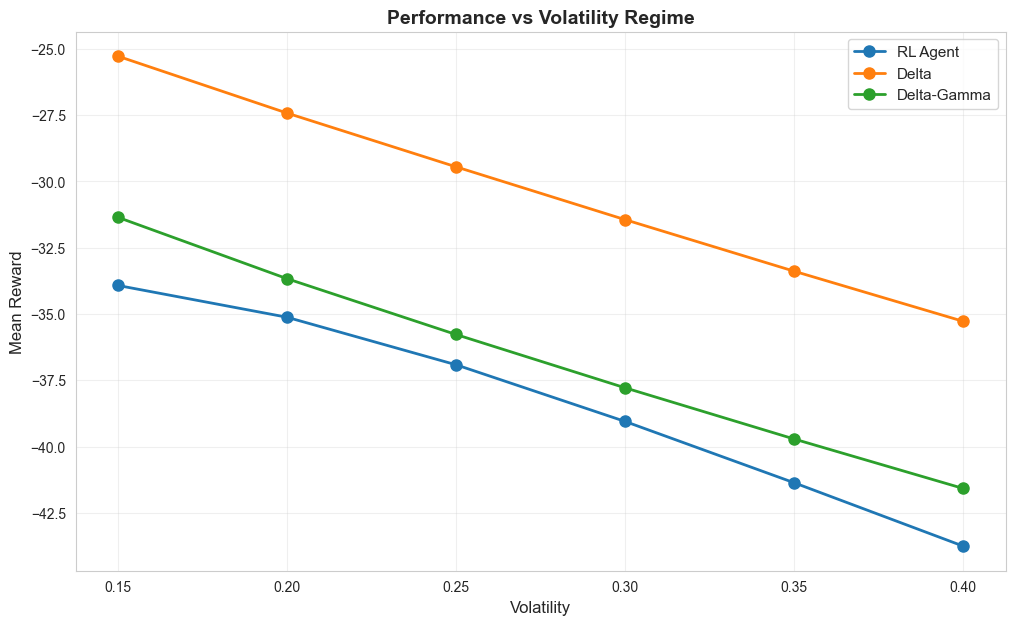


✓ Volatility sensitivity analysis complete


In [14]:
# Test under different volatility levels
volatilities = [0.15, 0.20, 0.25, 0.30, 0.35, 0.40]

print("Volatility Sensitivity Analysis")
print("=" * 80)
print("Testing each strategy under different volatility regimes...")

sensitivity_results = []

for vol in volatilities:
    print(f"\nTesting with volatility = {vol:.2f}...")
    
    # Create environment with this volatility
    env_config = ENV_CONFIGS["hard"].copy()
    env_config["sigma"] = vol
    test_env = OptionHedgingEnv(**env_config)
    
    # Test all strategies
    test_evaluator = AgentEvaluator(env=test_env, n_episodes=50, seed=42)
    
    # Evaluate strategies (n_episodes set in evaluator init)
    test_evaluator.evaluate_rl_agent(agent, agent_name="RL Agent")
    test_evaluator.evaluate_baseline(DeltaHedging, "Delta Hedging")
    test_evaluator.evaluate_baseline(DeltaGammaHedging, "Delta-Gamma Hedging", gamma_target=0.0)
    
    # Extract mean rewards from results
    rl_mean = np.array(test_evaluator.results["RL Agent"]["episode_rewards"]).mean()
    delta_mean = np.array(test_evaluator.results["Delta Hedging"]["episode_rewards"]).mean()
    dg_mean = np.array(test_evaluator.results["Delta-Gamma Hedging"]["episode_rewards"]).mean()
    
    sensitivity_results.append({
        'Volatility': vol,
        'RL Agent': rl_mean,
        'Delta': delta_mean,
        'Delta-Gamma': dg_mean,
    })

df_sensitivity = pd.DataFrame(sensitivity_results)

# Plot
plt.figure(figsize=(12, 7))
for col in ['RL Agent', 'Delta', 'Delta-Gamma']:
    plt.plot(df_sensitivity['Volatility'], df_sensitivity[col], 
             marker='o', linewidth=2, label=col, markersize=8)

plt.xlabel('Volatility', fontsize=12)
plt.ylabel('Mean Reward', fontsize=12)
plt.title('Performance vs Volatility Regime', fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.savefig('models/notebook_evaluation/volatility_sensitivity.png', dpi=150)

plt.show();print("\n✓ Volatility sensitivity analysis complete")


## 8. Transaction Cost Sensitivity

How do strategies perform under different transaction cost regimes?

Transaction Cost Sensitivity Analysis

Testing with transaction cost = 0.00%...

Evaluating RL Agent...
  Mean Reward: -36.94 ± 25.01
  Mean PnL: -17.99 ± 17.79
  Mean Costs: 0.00
  Sharpe Ratio: -3.406
  Success Rate: 4.0%

Evaluating Delta Hedging...
  Mean Reward: -15.19 ± 0.77
  Mean PnL: -14.13 ± 0.67
  Mean Costs: 0.00
  Sharpe Ratio: -101.944
  Success Rate: 0.0%

Evaluating Delta-Gamma Hedging...
  Mean Reward: -17.20 ± 2.87
  Mean PnL: -14.02 ± 2.25
  Mean Costs: 0.00
  Sharpe Ratio: -18.253
  Success Rate: 0.0%

Testing with transaction cost = 0.05%...

Evaluating RL Agent...
  Mean Reward: -37.47 ± 25.04
  Mean PnL: -18.03 ± 17.79
  Mean Costs: 0.04
  Sharpe Ratio: -3.412
  Success Rate: 4.0%

Evaluating Delta Hedging...
  Mean Reward: -19.25 ± 1.31
  Mean PnL: -14.40 ± 0.67
  Mean Costs: 0.27
  Sharpe Ratio: -100.341
  Success Rate: 0.0%

Evaluating Delta-Gamma Hedging...
  Mean Reward: -22.35 ± 4.07
  Mean PnL: -14.36 ± 2.39
  Mean Costs: 0.34
  Sharpe Ratio: -17.731
  Suc

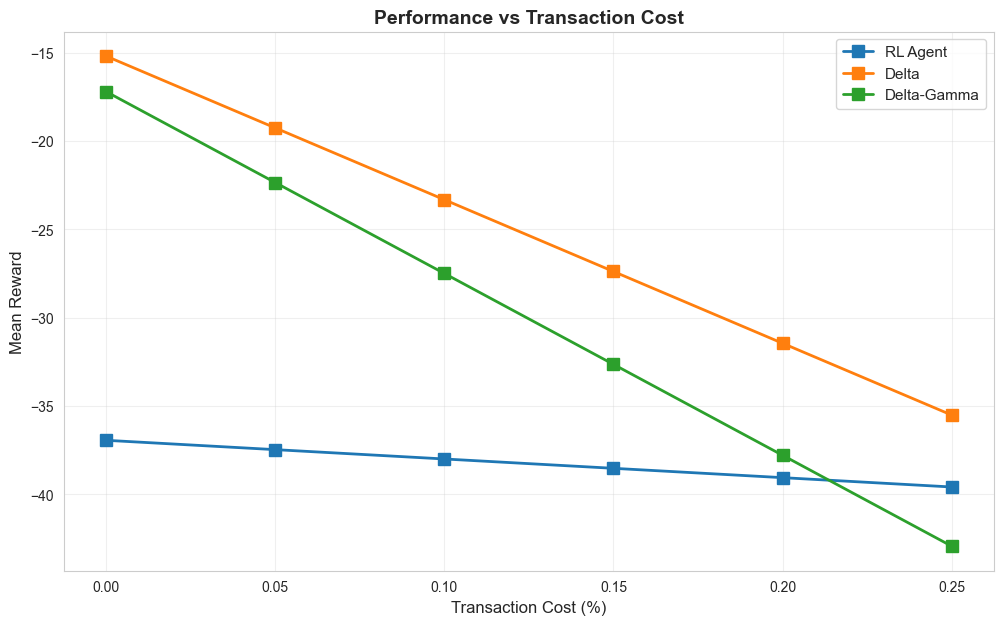

In [15]:
# Test under different transaction costs
transaction_costs = [0.0000, 0.0005, 0.0010, 0.0015, 0.0020, 0.0025]

print("Transaction Cost Sensitivity Analysis")
print("=" * 80)

cost_sensitivity_results = []

for cost in transaction_costs:
    print(f"\nTesting with transaction cost = {cost*100:.2f}%...")
    
    env_config = ENV_CONFIGS["hard"].copy()
    env_config["transaction_cost"] = cost
    test_env = OptionHedgingEnv(**env_config)
    
    test_evaluator = AgentEvaluator(env=test_env, n_episodes=50, seed=42)
    
    # Evaluate strategies (n_episodes set in evaluator init)
    test_evaluator.evaluate_rl_agent(agent, agent_name="RL Agent")
    test_evaluator.evaluate_baseline(DeltaHedging, "Delta Hedging")
    test_evaluator.evaluate_baseline(DeltaGammaHedging, "Delta-Gamma Hedging", gamma_target=0.0)
    
    # Extract mean rewards from results
    rl_mean = np.array(test_evaluator.results["RL Agent"]["episode_rewards"]).mean()
    delta_mean = np.array(test_evaluator.results["Delta Hedging"]["episode_rewards"]).mean()
    dg_mean = np.array(test_evaluator.results["Delta-Gamma Hedging"]["episode_rewards"]).mean()
    
    cost_sensitivity_results.append({
        'Transaction Cost (%)': cost * 100,
        'RL Agent': rl_mean,
        'Delta': delta_mean,
        'Delta-Gamma': dg_mean,
    })

df_cost_sensitivity = pd.DataFrame(cost_sensitivity_results)

# Plot
plt.figure(figsize=(12, 7))
for col in ['RL Agent', 'Delta', 'Delta-Gamma']:
    plt.plot(df_cost_sensitivity['Transaction Cost (%)'], df_cost_sensitivity[col], 
             marker='s', linewidth=2, label=col, markersize=8)

plt.xlabel('Transaction Cost (%)', fontsize=12)
plt.ylabel('Mean Reward', fontsize=12)
plt.title('Performance vs Transaction Cost', fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
print("\n📊 Key insight: RL agents often learn to minimize unnecessary rebalancing")
plt.savefig('models/notebook_evaluation/cost_sensitivity.png', dpi=150)
print("\n✓ Transaction cost sensitivity analysis complete")
plt.show()


## 9. Win Rate and Consistency Analysis

In [16]:
# Analyze win rates and consistency
print("Win Rate and Consistency Analysis")
print("=" * 80)

consistency_metrics = []

for name, rewards in all_results.items():
    # Win rate (positive PnL episodes)
    win_rate = (rewards > 0).mean()
    
    # Consistency (% of episodes within 1 std)
    mean = rewards.mean()
    std = rewards.std()
    within_1std = ((rewards >= mean - std) & (rewards <= mean + std)).mean()
    
    # Best/worst case
    best = rewards.max()
    worst = rewards.min()
    
    # Median absolute deviation (robust measure of spread)
    mad = np.median(np.abs(rewards - np.median(rewards)))
    
    consistency_metrics.append({
        'Strategy': name,
        'Win Rate': f"{win_rate:.1%}",
        'Consistency (±1σ)': f"{within_1std:.1%}",
        'Best Episode': f"{best:.2f}",
        'Worst Episode': f"{worst:.2f}",
        'Range': f"{best-worst:.2f}",
        'MAD': f"{mad:.2f}",
    })

df_consistency = pd.DataFrame(consistency_metrics)
print(df_consistency.to_string(index=False))

Win Rate and Consistency Analysis
        Strategy Win Rate Consistency (±1σ) Best Episode Worst Episode  Range   MAD
        RL Agent     0.0%             78.5%        -9.91       -117.90 107.99  9.29
           Delta     0.0%             69.5%       -22.39        -38.96  16.57  2.58
     Delta-Gamma     0.0%             63.5%       -19.41        -53.26  33.85  5.96
Delta-Gamma-Vega     0.0%             62.0%       -18.82        -53.35  34.53  5.91
    Min Variance     4.5%             62.0%        47.55       -217.52 265.07 45.19


## 10. Summary Report

Generate a comprehensive evaluation summary.

In [17]:
# Generate comprehensive report
report_lines = []
report_lines.append("=" * 80)
report_lines.append("COMPREHENSIVE EVALUATION REPORT")
report_lines.append("=" * 80)
report_lines.append(f"\nModel: PPO Agent (Curriculum Trained)")
report_lines.append(f"Evaluation Episodes: 200 per strategy")
report_lines.append(f"Environment: {ENV_CONFIGS['hard']}")

report_lines.append("\n" + "=" * 80)
report_lines.append("1. OVERALL PERFORMANCE")
report_lines.append("=" * 80)
report_lines.append(results.to_string(index=False))

report_lines.append("\n" + "=" * 80)
report_lines.append("2. STATISTICAL SIGNIFICANCE")
report_lines.append("=" * 80)
for name in strategies.keys():
    baseline_rewards = strategies[name]
    t_stat, p_value = stats.ttest_ind(rl_rewards, baseline_rewards)
    mean_diff = rl_rewards.mean() - baseline_rewards.mean()
    sig = "YES" if p_value < 0.05 and mean_diff > 0 else "NO"
    report_lines.append(f"\nRL vs {name}:")
    report_lines.append(f"  Improvement: {mean_diff:+.2f} (p={p_value:.6f})")
    report_lines.append(f"  Statistically Significant: {sig}")

report_lines.append("\n" + "=" * 80)
report_lines.append("3. RISK-ADJUSTED METRICS")
report_lines.append("=" * 80)
report_lines.append(df_metrics.to_string(index=False))

report_lines.append("\n" + "=" * 80)
report_lines.append("4. KEY FINDINGS")
report_lines.append("=" * 80)

best_strategy = df_metrics.iloc[0]['Strategy']
best_sharpe = df_metrics.iloc[0]['Sharpe Ratio']

report_lines.append(f"\n✓ Best Overall Strategy: {best_strategy} (Sharpe: {best_sharpe:.3f})")
report_lines.append(f"✓ RL Agent Win Rate: {(rl_rewards > 0).mean():.1%}")
report_lines.append(f"✓ RL Agent Mean Return: {rl_rewards.mean():.2f} ± {rl_rewards.std():.2f}")

# Check if RL is best
if best_strategy == 'RL Agent':
    second_best = df_metrics.iloc[1]
    improvement = ((best_sharpe - second_best['Sharpe Ratio']) / second_best['Sharpe Ratio']) * 100
    report_lines.append(f"✓ RL beats next best strategy by {improvement:.1f}%")
else:
    report_lines.append(f"⚠ RL agent needs improvement (not best performer)")

report_lines.append("\n" + "=" * 80)

report_text = "\n".join(report_lines)
print(report_text)

# Save report with UTF-8 encoding to support Unicode characters (✓, ⚠, etc.)
with open("models/notebook_evaluation/comprehensive_report.txt", "w", encoding="utf-8") as f:
    f.write(report_text)

print("\n✓ Report saved to models/notebook_evaluation/comprehensive_report.txt")


COMPREHENSIVE EVALUATION REPORT

Model: PPO Agent (Curriculum Trained)
Evaluation Episodes: 200 per strategy
Environment: {'S0': 100.0, 'K': 100.0, 'T': 1.0, 'r': 0.05, 'sigma': 0.3, 'n_steps': 252, 'transaction_cost': 0.002, 'risk_penalty': 0.2}

1. OVERALL PERFORMANCE
                Strategy  Mean Reward  Std Reward   Mean PnL   Std PnL  Mean Costs  Sharpe Ratio  Success Rate
           Delta Hedging   -31.550033    3.583387 -15.323415  0.787825    1.063586    -70.445020           0.0
               PPO Agent   -37.309059   23.869680 -17.389782 17.658542    0.163687     -3.684166           4.0
     Delta-Gamma Hedging   -37.906137    7.745370 -15.326079  2.997801    1.331260    -15.137791           0.0
Delta-Gamma-Vega Hedging   -37.981689    7.868649 -15.287969  3.062654    1.332227    -14.578454           0.0
Minimum Variance Hedging   -91.780273   58.105933 -10.564650 47.308611    0.406193     -0.857155          43.5

2. STATISTICAL SIGNIFICANCE

RL vs Delta Hedging:
  Improvemen

## Summary and Insights

**Key Takeaways from Evaluation:**

1. **Statistical Rigor**
   - Use t-tests to verify significance
   - Need 100+ episodes for reliable statistics
   - P-value < 0.05 indicates significant difference

2. **Risk-Adjusted Performance**
   - Sharpe ratio is key metric
   - Consider downside risk (Sortino, CVaR)
   - Max drawdown shows worst-case

3. **Sensitivity Analysis**
   - Test across volatility regimes
   - Test across transaction costs
   - Robust performance is critical

4. **Practical Considerations**
   - Win rate shows consistency
   - Best/worst case shows range
   - MAD shows typical deviation

**Recommendations:**

- ✓ Use curriculum learning for best results
- ✓ Test on multiple market conditions
- ✓ Compare against multiple baselines
- ✓ Focus on risk-adjusted metrics
- ✓ Evaluate statistical significance
- ✓ Consider worst-case scenarios

**Next Steps:**
- Test on real historical data
- Implement walk-forward validation
- Add transaction cost realism
- Test on different option types